# An Numerical solution for Time Delay PDE

My idea comes from my previous job in an old style glass manufactory. There was a large furnace lying in the middle of the factory. Originally, I want to check out he heat transfer and distribution inside the furnace. In according to Wang (1963), the product that has to be heat treaded was feed into the furnace, the temperature of the furnace was controlled by the heat controller which could be considered as the boundary conditions.  The following is the equation he used todescribe the working condition of the furnace. 

$$\frac{\partial u(t,x)}{\partial t} = k\frac{\partial^2 u(t,x)}{\partial x^2} +v(g(u(t-\tau_1)))\frac{\partial u(t,x)}{\partial x} +c(f(u(t -\tau _2))-u(t,x))$$

Unfortunately, I cannot find more details about this equation, for it has been written about 60 years. But the equation itself is an interesting top until now, a time delay partial deferential equation(DPDE). So in my project, I want to talk about solving a specific nonlinear delay convection-reaction–diffusion equation in 1D and 2D. Let’s go. 

## 1D Problem

Firstly, we start with the easier 1D diffusion. Here comes the equation. 

$$\frac{\partial u(t,x)}{\partial t} = \alpha\frac{\partial^2 u(t,x)}{\partial x^2} +\beta\frac{\partial u(t,x)}{\partial x} +u(x,t)(1 -u(x,t-\tau))+f(t,x)),  (x,t)\in(0,T]$$

where $f(x,t) = \alpha e^t cos(x)+\beta e^tsin(t)+e^{2t-\tau}sin^2(x), \alpha = \beta =1, a = 0, b = 1, T =2, s= 0.1$, initial and boundary condtions are determined by the exat solution $u(x,t)= e^tsin(x)$

### Discretization

we could use a forward-time, Center Difference scheme to discretize this second-order derivative as following:

$$\frac{u_{i}^{n+1} - u_{i}^{n}}{\Delta t} =  \frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{2\Delta x} - \frac{(u_{i+1}^{n}-u_{i}^{n})}{\Delta x} + u_{i}^{n}(1 - u_{i}^{n-s}) +f(x,t)$$

now let's begin 

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
from matplotlib import animation
from IPython.display import HTML
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Initial conditions setting, don’t forget the stability constraint:$\frac{\Delta t}{\Delta x^2}\leqslant \frac{1}{2}$

In [2]:
#initial conditions 
nt = 1001
nx = 51

s = 0.1
T = 2
L = numpy.pi
dx = L/(nx-1)
dt = T/(nt-1)

x = numpy.linspace(0, L, nx)

u = numpy.zeros(nx)
u0 = numpy.sin(x)                  #IC, when t goes to 0

Before solving the whole function, we define the f(x,t) function which will applied into the main function first.

In [3]:
def fxt(x,t):
    """solves the solution for f(x,t)
    Parameters:
    ----------
    x:array of float
      the position 
    t:float
      time
    
    Returns:
    -------
    fxt: array of float
         the solution for f(x,t)
    """
    fxt = numpy.exp(t) * numpy.cos(x) + \
          numpy.exp(t) * numpy.sin(t) + \
          numpy.exp(2*t - s) * numpy.sin(x)**2
            
    return fxt

Here we got a time delay term $u_{i}^{n}(1 - u_{i}^{n-s})$, which will use the previous solution. what I have done is to establish an n+1 matrix to storage the solution of u at every time step. 

In [4]:
def func_u(u, x, nt, dt, dx,s):
    """solves the DPDE with forward time center difference scheme
    Parameters:
    ----------
    u: array of float
       intiial condition of u
    x: array of float
       position
    nt: int
        number of time step
    dt: float
        time increment
    dx: float
        delta x
    s: float
       time delay
       
    Returns:
    -------
    u: array of float
       solutions for the DPDE
    """
    un = numpy.zeros_like(u)
    unt = numpy.zeros((nt+1,nx))
    
    i = 0
    
    for n in range(nt):
        
        tn = i-int(s/dt)
        un = u.copy()
        u[1:-1] = un[1:-1] + \
                  dt/dx**2*(un[2:] - 2*un[1:-1] + un[0:-2]) -\
                  dt/dx*(un[2:] - un[1:-1]) + \
                  dt*un[1:-1] * (1-unt[tn,1:-1]) + dt*fxt(x,dt*i)[1:-1] 
                               
        u[0] = 0                                                    #BC
        u[-1] = numpy.exp(dt*i)*numpy.sin(L)                        #BC
        unt[i,:] = u[:]                                             #update time delay term for the futher use
        i = i + 1
        
    return u

In [5]:
u_num = func_u(u0.copy(), x, nt, dt, dx,s)
u_exact = numpy.exp(T)*numpy.sin(x)

ready to see what we have done? Beacuse of the equation has the exact solution, lets plot them together!

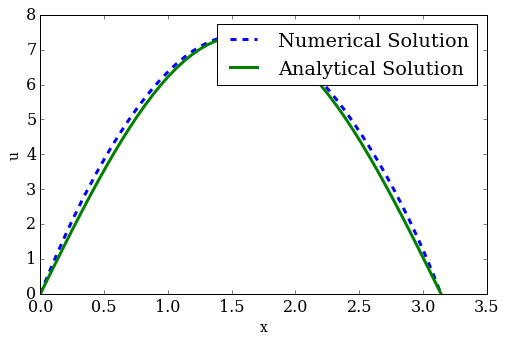

In [6]:
pyplot.figure(figsize=(8,5))
pyplot.xlabel('x', fontsize=14) 
pyplot.ylabel('u', fontsize=14) 
pyplot.plot(x, u_num, ls='--', lw=3)
pyplot.plot(x, u_exact, ls='-', lw=3)
pyplot.legend(['Numerical Solution','Analytical Solution']);

### Calculate the error

Now we have the solution of u at every step and want to know the error between the exat solution.

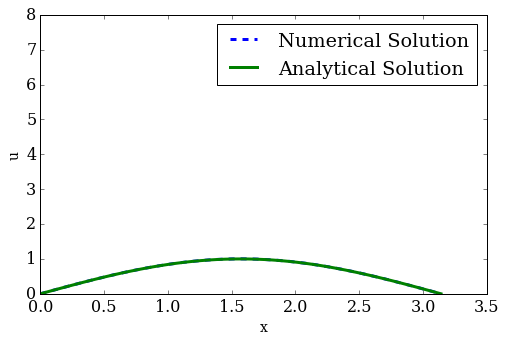

In [7]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,3.5), ylim=(0,8))
line = ax.plot([], [], ls='--', lw=3)[0]
line2 = ax.plot([], [], ls='-', lw=3)[0]
pyplot.xlabel('x', fontsize=14) 
pyplot.ylabel('u', fontsize=14) 
ax.legend(['Numerical Solution','Analytical Solution'])

unt = numpy.zeros((nt+1,nx))
u = u0

def time_delay(n):
    
    un = u.copy()
    tn = n-int(s/dt)
    
    u[1:-1] = un[1:-1] + \
              dt/dx**2*(un[2:] - 2*un[1:-1] + un[0:-2]) -\
              dt/dx*(un[2:] - un[1:-1]) + \
              dt*un[1:-1] * (1-unt[tn,1:-1]) + dt*fxt(x,dt*n)[1:-1]
                               
    u[0] = 0                                                 
    u[-1] = numpy.exp(dt*n)*numpy.sin(L)                      
    unt[n,:] = u[:]                                           
    

    u_exact = numpy.exp(n*dt)*numpy.sin(x)   
    line.set_data(x,u)
    line2.set_data(x,u_exact) 
        
        
anim = animation.FuncAnimation(fig, time_delay,frames=nt,interval=10)

ready to move?

In [8]:
HTML(anim.to_html5_video())

From the animation we can check out that there is more error in the beginning, that’s meanly because there is no value for the time delay term $u^{n-s}_i$, when the time step goes, when the time delay term has the value, the solution gets more accurate.

## 2D problem

Let’s move to 2D part, in 2D, the equation becomes to 

$$\frac{\partial u}{\partial t} = \alpha \nabla^2 u +\beta\nabla u +u(x,y,t)(1 -u(x,y,t-\tau))+f(t,x,y))$$

Here we simpily use the ICs in the 1D problem again, $f(t,x,y)$ becomes to $f(x,y,t) = \alpha e^t (cos(x) +cos(y))+2\beta e^tsin(t)+e^{2t-\tau}(sin^2(x) + sin^2(y))$

In [14]:
#setup ICs
L = numpy.pi
H = numpy.pi

nx = 31
ny = 31
nt = 1001

dx = L/(nx-1)
dy = H/(ny-1)
dt = T/(nt-1)

s = 0.1
T = 2

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

u = numpy.zeros((ny, nx))

#set initila condition for u0
u1 = numpy.zeros_like(u)
u2 = numpy.zeros_like(u)
for n in range(ny):
    u1[n:] = numpy.sin(y)
for n in range(nx):
    u2[:,n] = numpy.sin(x)
u0 = u1 + u2

generate he solution of function $f(x,y,t)$ into $n \times n$ matrix which will easy to use in the main function

In [19]:
def ft_2d(x,y,t):
    """generate a nxn matrix with x and y
    Parameters:
    ----------
    x: array of float
       x positon 
    y: array of float
       y position
    t: float
       time
    Returns:
    -------
    ft: matrix of float
        generate a matrix with x and y
    """
    ft = numpy.zeros_like(u)
    fty = numpy.zeros_like(u)
    ftx = numpy.zeros_like(u)
    
    ft1 = fxt(x,t)
    ft2 = fxt(y,t)
    
    for n in range(ny):
        fty[n,:] = ft2               #every line equal to ft2
    for n in range(nx):
        ftx[:,n] = ft1               #every column equal to ft1
    
    ft = ftx + fty
    
    return ft

Just like 1D, we add a n+1 matrix to storge the value of u at every time step, set the top bottom and right boundary condition as Neumann boundary, which is $\frac{\partial u}{\partial x} = q(x) = 0$ 

In [23]:
def func_u_2d(u, x, y, nt, dt, dx, dy, s):
    """solves the DPDE with forward time center difference scheme
    Parameters:
    ----------
    u: array of float
       intiial condition of u
    x: array of float
       position
    y: array of float
       position  
    nt: int
        number of time step
    dt: float
        time increment
    dx: float
        delta x
    dy: float
        delta y
    s: float
       time delay
       
    Returns:
    -------
    u: array of float
       solutions for the DPDE
    """
    un = numpy.zeros_like(u)
    unt = numpy.zeros((nt+1,ny,nx))
    
    i = 0
    
    for n in range(nt):
        
        tn = i-int(s/dt)
        un = u.copy()
        u[1:-1,1:-1] = un[1:-1,1:-1] + \
                       dt/dy**2*(un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1]) +\
                       dt/dx**2*(un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2]) -\
                       dt/dy*(un[2:,1:-1] - un[1:-1,1:-1]) - \
                       dt/dx*(un[1:-1,2:] - un[1:-1,1:-1]) + \
                        dt*ft_2d(x,y,dt*i)[1:-1,1:-1] + dt*un[1:-1,1:-1] * (1-unt[tn,1:-1,1:-1])
                               
        #BCs
        u[-1,:] = u[-2,:]             #top
        #u[0,1:-1] =                  #bottom
        u[:,0] = u[:,1]               #left
        u[:,-1] = u[:,-2]             #right
        
        unt[i,:,:] = u[:,:]           #update time delay term for the futher use
        i = i + 1
        
    return u

In [24]:
U = func_u_2d(u0.copy(), x, y, nt, dt, dx, dy, s)

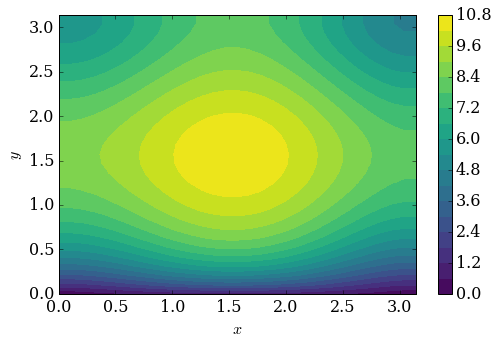

In [25]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(x,y,U,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();